### Load cleaned data and pre-defined classes

In [62]:
from data_clean import Data_to_Clean,Data_to_Analyze
import pickle
import pandas as pd
import copy
import json

MBTI_types=[
    "ISTJ", "ISFJ", "INFJ", "INTJ",
    "ISTP", "ISFP", "INFP", "INTP",
    "ESTP", "ESFP", "ENFP", "ENTP",
    "ESTJ", "ESFJ", "ENFJ", "ENTJ"
]
cleaned_data=dict.fromkeys(MBTI_types, None)

for type in cleaned_data.keys():
    file_path=f"Data\\cleaned_data\\{type}_cleaned.pkl" 
    try:
        with open(file_path, 'rb') as f:
            cleaned_data[type] = pickle.load(f)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except pickle.UnpicklingError:
        print(f"Error: Could not unpickle the file {file_path}. It might be corrupted or not a valid pickle file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


In [63]:
infp=cleaned_data["INFP"]
infp.data.head(30)
infp.data.to_csv("Data/infp.csv")

### Visualize VADER score of all MBTI types

In [64]:
all_vader_scores={T:cleaned_data[T].basic_identities["overall_vader_score"] for T in MBTI_types}

In [65]:
all_vader_scores=pd.DataFrame(all_vader_scores).T

In [66]:
all_vader_scores=all_vader_scores.sort_values(by="compound",ascending=False)
all_vader_scores

,neg,neu,pos,compound
ISFJ,0.073075,0.709295,0.178081,0.158091
ENFJ,0.075742,0.709277,0.171599,0.148587
INFJ,0.075847,0.709754,0.170428,0.147531
ESTJ,0.073826,0.718807,0.166875,0.138037
ESFJ,0.077685,0.709228,0.163119,0.128958
ENFP,0.080021,0.719648,0.162310,0.127794
INTJ,0.076465,0.727312,0.155606,0.118534
INFP,0.084385,0.711518,0.162910,0.115201
ISFP,0.083938,0.711919,0.164746,0.111911
ENTJ,0.081139,0.721489,0.156149,0.107433


In [67]:
all_vader_scores["compound"].describe()

count    16.000000
mean      0.115503
std       0.024317
min       0.078986
25%       0.096175
50%       0.113556
75%       0.131228
max       0.158091
Name: compound, dtype: float64

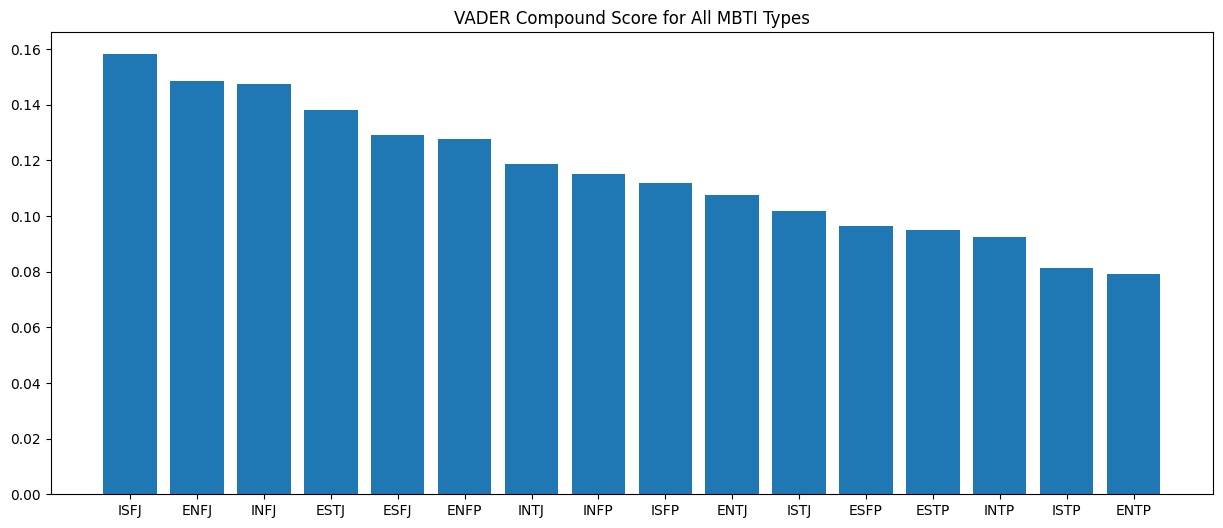

In [68]:
import matplotlib.pyplot as plt
x=all_vader_scores.index
y=all_vader_scores["compound"]
plt.figure(figsize=(15, 6))
plt.bar(x,y)
plt.title("VADER Compound Score for All MBTI Types")
plt.show()

### Construct a dictionary for LDA modeling

In [69]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel
def constract_initial_dict():
    output = {T: {
        "corpus_overall": None,
        "corpus_specific": None,
        "original_text": [],
        "specific_initial_dict": None
    } for T in MBTI_types}
    def concatenate_post(post):
        complete_post=[]
        for sentence in post:
            complete_post.extend(sentence)
        return complete_post
    output["all_original_text"]=[]
    for T in MBTI_types:
        for i in cleaned_data[T].data.index:
            temp=concatenate_post(cleaned_data[T].data.loc[i,"posts"])
            cleaned_data[T].data.at[i,"posts"]=temp
            output[T]["original_text"].append(temp)
        output["all_original_text"].extend(output[T]["original_text"])
        output[T]["specific_initial_dict"]=corpora.Dictionary(output[T]["original_text"])
        output[T]["specific_initial_dict"].filter_extremes(no_above=0.3,no_below=15)
        output[T]["specific_initial_dict"].compactify()
        output[T]["corpus_specific"]=[output[T]["specific_initial_dict"].doc2bow(post_token) for post_token in output[T]["original_text"]]
    output["overall_initial_dict"]=corpora.Dictionary(output["all_original_text"])
    output["overall_initial_dict"].filter_extremes(no_above=0.2,no_below=50)
    output["overall_initial_dict"].compactify()
    output["all_corpus"]=[output["overall_initial_dict"].doc2bow(post_token) for post_token in output["all_original_text"]]
    return output
initial_dict=constract_initial_dict()
with open("Data/initial_dict.pkl",'wb') as f:
    pickle.dump(initial_dict,f)


In [70]:
def check_corpus(corpus,dict):
    result=pd.DataFrame(
        [
            list(range(len(dict))),
            [0]*len(dict)
        ]
    ).T
    result.columns=["word","frequency"]
    for post in corpus:
        for word_tuple in post:
            result.loc[word_tuple[0],"frequency"]+=word_tuple[1]
            #result.loc[word_tuple[0],"word"]=initial_dict["overall_initial_dict"][word_tuple[0]]
    for i in result.index:
        result.loc[i,"word"]=dict[i]
    result=result.sort_values(by="frequency",ascending=False)
    result.to_csv(r"Data\id2word_result.csv")
check_corpus(initial_dict["all_corpus"],initial_dict["overall_initial_dict"])

C:\Users\DominicMin\AppData\Local\Temp\ipykernel_15640\273948434.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'aaa' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[i,"word"]=dict[i]


In [71]:
initial_dict["overall_initial_dict"][266]

'sister'

### Create a class for modeling

In [72]:
with open("Data/initial_dict.pkl","rb") as f:
    initial_dict=pickle.load(f)
import gensim.corpora as corpora
import gensim
from tqdm import tqdm
from gensim.models import LdaMulticore,CoherenceModel
def optimize_topic_num(
  start,
  end,
  step,
  dict=initial_dict["overall_initial_dict"],
  corpus=initial_dict["all_corpus"],
  text=initial_dict["all_original_text"]      
):
  output=pd.Series({},dtype=float)
  topic_num_range = range(start, end+1, step)
  for topic_num in tqdm(topic_num_range, desc="计算全局模型主题数"):
  # 训练 LDA 模型 (在所有帖子数据上)
    temp_lda_model = LdaMulticore(
        corpus=corpus,    # 使用所有帖子的词袋语料
        id2word=dict,         # 使用全局词典
        num_topics=topic_num,
        random_state=100,
        chunksize=2500,
        passes=10,
        alpha="asymmetric",
        eta="auto",
        per_word_topics=False,
        workers=None                     
    )

    # 计算 Coherence (C_v) 分数 (评估全局模型在所有数据上的性能)
    temp_chmodel = CoherenceModel(
        model=temp_lda_model,
        texts=text,
        dictionary=dict,
        coherence="c_v"
    )
    output[topic_num] = temp_chmodel.get_coherence()
  print(output)
    

In [73]:
optimize_topic_num(7,50,7)

计算全局模型主题数: 100%|██████████| 7/7 [20:34<00:00, 176.29s/it]

7     0.443975
14    0.477833
21    0.547701
28    0.471463
35    0.467555
42    0.440087
49    0.411240
dtype: float64


In [74]:
optimize_topic_num(18,25,1)

计算全局模型主题数: 100%|██████████| 8/8 [13:09<00:00, 98.65s/it] 

18    0.475461
19    0.501089
20    0.500918
21    0.547701
22    0.503740
23    0.503906
24    0.476132
25    0.486884
dtype: float64


In [75]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

lda_model = LdaMulticore(
    corpus=initial_dict["all_corpus"],
    id2word=initial_dict["overall_initial_dict"],
    num_topics=21,
    random_state=100,
    chunksize=2500,
    passes=100,
    alpha="asymmetric",
    eta="auto",
    per_word_topics=False,
    workers=None,
    eval_every=10 # 每 10 次迭代计算一次困惑度/一致性，用于监控
)

2025-05-24 13:37:02,100 : INFO : using asymmetric alpha [0.12036041, 0.09880039, 0.08379101, 0.07274055, 0.06426517, 0.057558708, 0.052119702, 0.047619864, 0.04383528, 0.04060796, 0.03782327, 0.035395987, 0.03326146, 0.03136973, 0.029681604, 0.02816589, 0.026797457, 0.025555832, 0.024424171, 0.023388483, 0.022437058]
2025-05-24 13:37:02,103 : INFO : using serial LDA version on this node
2025-05-24 13:37:02,111 : INFO : running online LDA training, 21 topics, 100 passes over the supplied corpus of 7811 documents, updating every 52500 documents, evaluating every ~7811 documents, iterating 50x with a convergence threshold of 0.001000
2025-05-24 13:37:02,112 : INFO : training LDA model using 21 processes
2025-05-24 13:37:35,313 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2500/7811, outstanding queue size 1
2025-05-24 13:37:35,431 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #5000/7811, outstanding queue size 2
2025-05-24 13:37:35,553 : INFO : PROGR

In [76]:
# 获取所有主题的词语和权重
all_topics_words = lda_model.show_topics(num_topics=-1, num_words=10, formatted=False)

print("\nTopic-Word Distribution (Structured):")
for topic_id, topic_words_with_weights in all_topics_words:
    print(f"Topic {topic_id}:")
    for word, weight in topic_words_with_weights:
        print(f"  {word}: {weight:.4f}")
    print()


Topic-Word Distribution (Structured):
Topic 0:
  draw: 0.0085
  haha: 0.0064
  smile: 0.0042
  lovely: 0.0041
  welcome: 0.0039
  amazing: 0.0037
  ah: 0.0037
  hug: 0.0037
  kiss: 0.0036
  hahaha: 0.0035

Topic 1:
  na: 0.0565
  ko: 0.0386
  sa: 0.0345
  ako: 0.0264
  ng: 0.0246
  ang: 0.0220
  automatically: 0.0202
  lang: 0.0174
  po: 0.0144
  mo: 0.0140

Topic 2:
  vote: 0.0866
  update: 0.0348
  sell: 0.0204
  order: 0.0193
  instagram: 0.0162
  item: 0.0155
  comment: 0.0152
  exo: 0.0131
  pre: 0.0130
  heardle: 0.0120

Topic 3:
  state: 0.0059
  country: 0.0049
  trump: 0.0046
  american: 0.0044
  vote: 0.0042
  law: 0.0041
  gun: 0.0040
  america: 0.0037
  abortion: 0.0033
  government: 0.0032

Topic 4:
  ateez: 0.0552
  list: 0.0416
  track: 0.0393
  san: 0.0312
  sector: 0.0275
  pc: 0.0199
  hongjoong: 0.0187
  seonghwa: 0.0187
  yeosang: 0.0186
  yunho: 0.0173

Topic 5:
  anime: 0.0448
  chapter: 0.0403
  manga: 0.0299
  mint: 0.0176
  arc: 0.0121
  retweet: 0.0118
  ch: 